In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import models, transforms
import torchvision.transforms.functional as TF
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
from contrib import adf
import copy
import csv

# Fix seed for duplication
np.random.seed(123)
torch.manual_seed(123)

## Load data
Let's parse the CSV file of the CO2 dataset

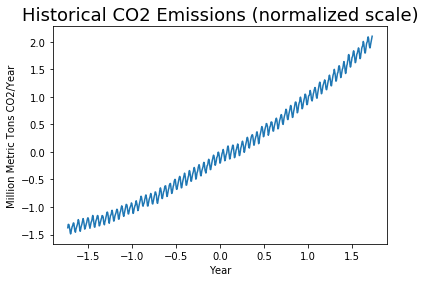

In [14]:
X = []
Y = []
with open('co2_mm_mlo.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        X.append(float(row['decimal date']))
        Y.append(float(row['average']))
X = np.array(X)
Y = np.array(Y)
# let's normalize and center the data
Y = (Y-np.mean(Y))/np.std(Y)
X = (X-np.mean(X))/np.std(X) 

plt.plot(X,Y)
plt.xlabel('Year')
plt.ylabel('Million Metric Tons CO2/Year')
plt.title('Historical CO2 Emissions (normalized scale)', fontsize=18)
plt.autoscale(tight=False)
plt.show()

# let's set the data loaders
X, Y = torch.unsqueeze(torch.Tensor(X),1), torch.unsqueeze(torch.Tensor(Y),1)
X, Y = Variable(X), Variable(Y)
CO2Dataset = TensorDataset(X, Y)
loader = DataLoader(dataset = CO2Dataset,
    batch_size = 128,
    shuffle=True)

## Train net

In [19]:
net = torch.nn.Sequential(
        torch.nn.Linear(1, 1024),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.1),
        torch.nn.Linear(1024, 1024),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.1),
        torch.nn.Linear(1024, 1024),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.1),
        torch.nn.Linear(1024, 1024),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.1),
        torch.nn.Linear(1024, 1024),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.1),
        torch.nn.Linear(1024, 1),
    )
net.train()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)

num_epochs = 40
for epoch in range(num_epochs):
    for i, data in enumerate(loader):
        years = data[0]
        concentrations = data[1]
  
        preds = net(years)
        loss = criterion(preds, concentrations)     

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    print(loss.data.numpy())

0.6339655
0.044798817
0.03243954
0.06896702
0.020202955
0.033179235
0.016902877
0.01052325
0.011569241
0.009330779
0.00933831
0.009752759
0.009498144
0.010033378
0.01165961
0.008313555
0.007626446
0.009550308
0.009618757
0.010959322
0.00975987
0.009242697
0.008989858
0.009823206
0.009245129
0.008749806
0.0087137045
0.009492225
0.009430505
0.008617912
0.009921424
0.0083115045
0.008347883
0.009482536
0.0105509
0.0093081305
0.0090163145
0.008714474
0.010621456
0.009411262


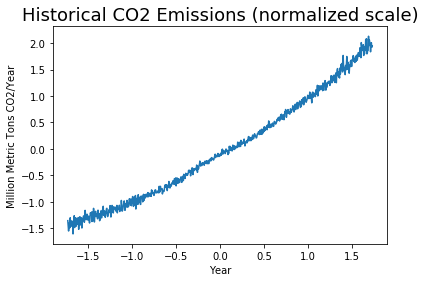

In [20]:
predictions = net(X)
plt.plot(X.squeeze().squeeze().numpy(),predictions.squeeze().squeeze().detach().numpy())
plt.xlabel('Year')
plt.ylabel('Million Metric Tons CO2/Year')
plt.title('Historical CO2 Emissions (normalized scale)', fontsize=18)
plt.autoscale(tight=False)
plt.show()